In [1]:
import sys
sys.path.append("/home/johnny/wilds/examples")
import wilds
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper

In [2]:
import json
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import entropy
from torchvision import datasets, transforms

In [3]:
full_dataset = wilds.get_dataset(
        dataset='civilcomments',
        root_dir='../../data',
        download=False)

In [4]:
train_dataset = full_dataset.get_subset('train')
test_dataset = full_dataset.get_subset('test')

In [92]:
trials_rs = []
for trial in glob('./civilcomments_rs_*.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_rs.append(rounds)
    
trials_us = []
for trial in glob('./civilcomments_us_1.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_us.append(rounds)

In [89]:
rounds[0].keys()

dict_keys(['train_size', 'train_idx', 'test_acc', 'test_preds', 'evals', 'probs'])

### Worst group accuracy

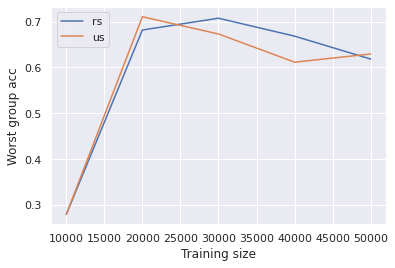

In [90]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = train_dataset.y_array[train_idx]
            x.append(len(train_idx))

            y.append(round['evals']['acc_wg'])

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Worst group acc' : y})
    sns.lineplot(data=df, x='Training size', y='Worst group acc', label=samp)

### Label balance

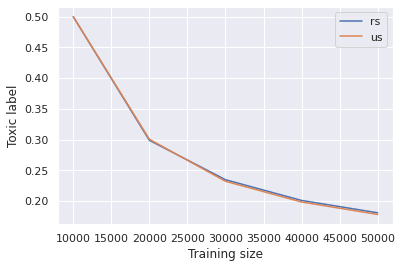

In [100]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = train_dataset.y_array[train_idx]
            x.append(len(train_idx))

            counts = pd.Series(train_labels).value_counts()
            y.append(counts.min() / counts.sum())

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Toxic label' : y})
    sns.lineplot(data=df, x='Training size', y='Toxic label', label=samp)

### Minority group balance

In [101]:
foi = train_dataset._metadata_fields.index('black')

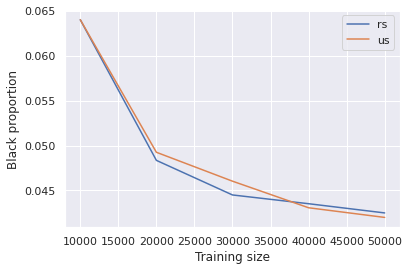

In [124]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = train_dataset.metadata_array[train_idx, foi]
            x.append(len(train_idx))

            counts = pd.Series(train_labels).value_counts()
            y.append(counts.min() / counts.sum())

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Black proportion' : y})
    sns.lineplot(data=df, x='Training size', y='Black proportion', label=samp)

### Minority acc

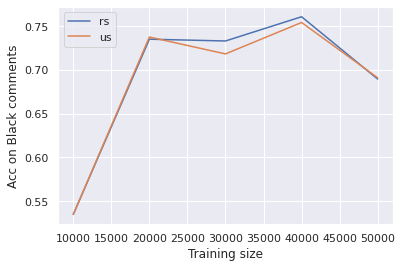

In [125]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = round['train_idx']
            x.append(len(train_idx))

            test_preds = np.array(round['test_preds']).argmax(axis=1)

            minority_group = test_dataset.y_array[test_dataset.metadata_array[:,foi] == 1]
            minority_group_ = test_preds[test_dataset.metadata_array[:,foi] == 1]

            minority_acc = np.mean(minority_group.numpy() == minority_group_)
            y.append(minority_acc)

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Acc on Black comments' : y})
    sns.lineplot(data=df, x='Training size', y='Acc on Black comments', label=samp)

In [104]:
black = test_dataset.metadata_array[:,foi]
black = black == 1
np.mean(test_dataset.y_array.numpy()[black])

0.31547619047619047

### Calibration

Automatically created module for IPython interactive environment


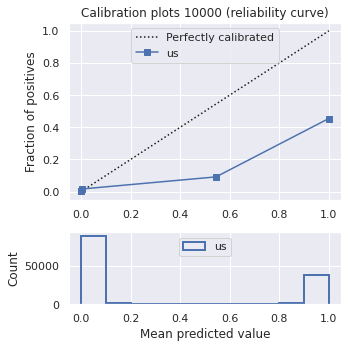

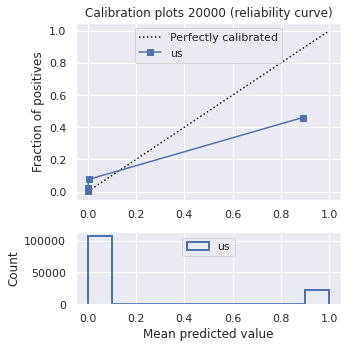

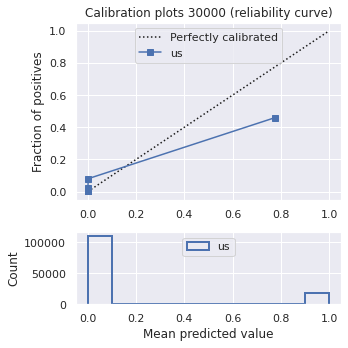

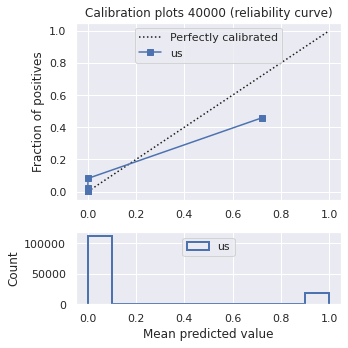

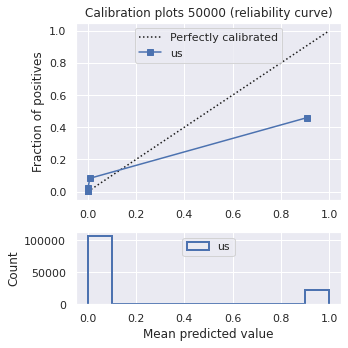

In [126]:
print(__doc__)

# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from scipy.special import softmax

# #############################################################################
# Plot calibration plots

x, y = [], []
for rounds in trials_us:
    for round in rounds:
        plt.figure(figsize=(5, 5))
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        
        train_idx = round['train_idx']
        probs = softmax(np.array(round['test_preds']), axis=1)
        labels = test_dataset.y_array
        
        prob_pos = probs[:, 1]
        y_test = labels
        
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=5, strategy='quantile')

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % ('us', ))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label='us',
                 histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="upper center")
        ax1.set_title('Calibration plots %d (reliability curve)' % len(train_idx))

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()
        plt.show()

In [ ]:
test_preds